In [1]:
import pylab as plt
import numpy as np
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr
from scipy import ndimage
from scipy.optimize import minimize

import sys as sys
import pickle
import glob as glob
import datetime as dt

sys.path.append('/home/ardhuin/TOOLS/swellSWOT/src/')
import swot_ssh_utils as swot
import swot_swell_utils as swell
from  lib_filters_obp import *


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import cmocean
import cmocean.cm as cmo
lightcmap = cmocean.tools.lighten(cmo.ice, 1)

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
from  spectral_analysis_functions import *
from  wave_physics_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,10],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

looking for files: /home/ardhuin/PUBLI/2025_Bolaven/data_package/data/SWOT_L3_LR_WIND_WAVE_005_328*v2.1_light_part.nc
sflip: 0   /home/ardhuin/PUBLI/2025_Bolaven/data_package/data/SWOT_L3_LR_WIND_WAVE_005_328_v2.1_light_part.nc
indices of selected spectra: 710 0
sflip: 0
n: 82981 519 250 235 0 59640


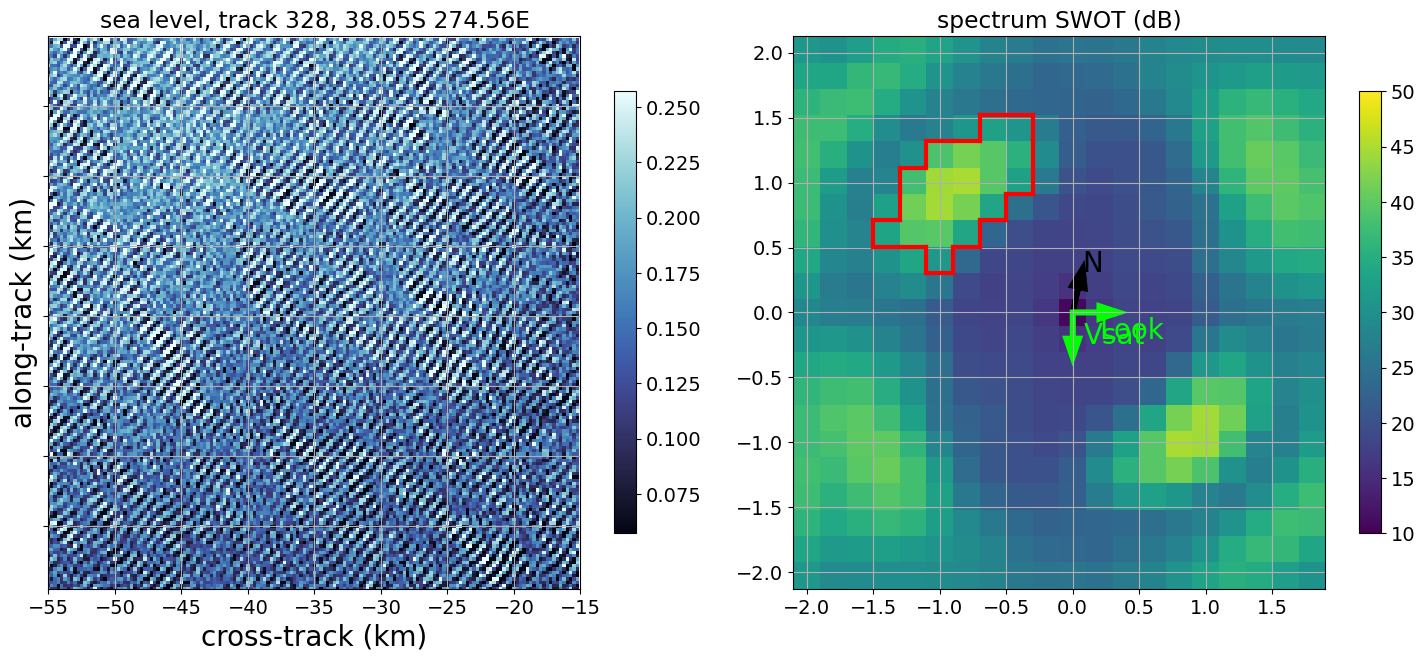

In [2]:
# now repeats the same processing using the newly generated L3 spectra output

mypath='/home/ardhuin/PUBLI/2025_Bolaven/data_package/'

# folder is the location of the data files with one example of spectrum file including partition information 
folder=mypath+'data/';tag='v2.1_light_part' # folder for spectra, and choice of filename extension; v2.1_light is for the home-made spectra

#folder=mypath+'data/';tag='v2.0' # folder for spectra, and choice of filename extension; v2.0 is for the v2 data available on AVISO
pth_swot='/media/ardhuin/FabLinux/SWOT2/'                       # folder for surface elevation maps (downloaded from ftp-access.aviso.altimetry.fr )


# defines the coordinates (space and time) of the storm center for which we get a swell mask
lo1=-173.5;la1=42.0; t1=np.datetime64('2023-10-16T01', 'ns'); rl=[600,1050]
# choice of SWOT cycle and track and choice of spectrum location along track 
cycle='005';tracks='328';ibox=710 


print('looking for files:',folder+'SWOT_L3_LR_WIND_WAVE_'+cycle+'_'+tracks+'*'+tag+'.nc' ) 
file_listnc = sorted(glob.glob(folder+'SWOT_L3_LR_WIND_WAVE_'+cycle+'_'+tracks+'*'+tag+'.nc'));

ntrack=int(tracks)
sflip=np.mod(ntrack,2)
print('sflip:',sflip,' ',file_listnc[0])
L3Snc=xr.open_dataset(file_listnc[0])

indx=np.mod(ibox,2)
print('indices of selected spectra:',ibox,indx) #, ', partition height (m):', L3Snc.Hpart[ibox].values)

la2=L3Snc['latitude'][ibox].values
lo2=L3Snc['longitude'][ibox].values
alpha,beta=swell.dist_sphere(lo1,lo2,la1,la2)
angt=L3Snc['track_angle'][ibox].values
now=L3Snc.time[ibox].values

# tdiff is the time difference between storm time ts and observation time to
tdiff=(now-t1);tds = tdiff / np.timedelta64(1, 's')
kx2=L3Snc['fx2D'].values
ky2=L3Snc['fy2D'].values

# defines swell mask from storm 
bmask,cmask=swell.SWOTdefine_swell_mask_storm(kx2,ky2,angt-180,lo1,la1,lo2,la2,tds,tola=20E5,tolr=0.25,thrcos=0.89)
nmask=np.sum(bmask.flatten())
if nmask > 1:
       E_SWOT=L3Snc['Efxfy_SWOT'][ibox,:,:]
       Hsnew,Lmm1new,LE,Lmnew,dmnew,spr,Q18=swell.SWOTspec_to_HsLm(E_SWOT,kx2,ky2,bmask,E_SWOT*0+1,angt)

vertices=swell.SWOTspec_mask_polygon(bmask) 
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6.5))
plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)

ax=axs[1]
im=ax.pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT),cmap='viridis',rasterized=True,vmin=10, vmax=50)
_=plt.colorbar(im,ax=axs[1],label='', location='right',shrink=0.8)
_=ax.set_title('spectrum SWOT (dB)') #+f'{la2:03.1f}')
swell.arrows_on_spectrum(axs[1],1-sflip,indx,angt-180,color='k')

dkx=kx2[0,1]-kx2[0,0]
dky=ky2[1,0]-ky2[0,0]
swell.draw_mask(axs[1],kx2,dkx,ky2,dky,vertices,color='r',lw=3)

print('sflip:',sflip)

ax=axs[0]

file_list = glob.glob(pth_swot+'SWOT_L3_LR_SSH_*Unsmoothed_'+cycle+'_'+tracks+'*.nc')
number_res=1; spectra_res='alpha'
dx,dy,indxc,ISHIFT,nkxr,nkyr,restab,nX2tab,nY2tab,mtab,ntab,indl,dind,samemask,hemiNS,hemiWE=swell.spec_settings_for_L3(number_res,spectra_res);
fs1=20
if (len(file_list) > 0) : 
# now gets the indices of the SSH map from the SWOT data (will only work with homemade spectra) 
   j1=L3Snc['boxindices'][ibox,0].values;j2=L3Snc['boxindices'][ibox,1].values  
   i1=L3Snc['boxindices'][ibox,2].values;i2=L3Snc['boxindices'][ibox,3].values
   file_swot=file_list[0]
   tags=file_swot.split(sep='/')
   ddl = xr.open_dataset(file_swot)
   ssha = ddl.ssha_unedited
   lat = ddl.latitude.values
   lon = ddl.longitude.values
   ISHIFT=60
   dlat=lat[j2,indxc+ISHIFT]-lat[j1,indxc+ISHIFT]
   sig0 = ddl.sigma0 #sig0_karin_2
   flas = ddl.quality_flag # sig0_karin_2_qual
   [nline,npix]=np.shape(ssha)
   X=(np.arange(npix)-indxc)*dx/1000
   indsub0=0
   shifty=j1
   print('n:',nline,npix,dx,dy,indsub0,shifty)
   Y=(np.arange(nline)+indsub0-shifty)*dy/1000 # warning the along-track resolutionis not exactly 250 m, more like 235 m 

   Xmem=X;
   Ymem=Y;
   mybox,mybos,flbox,X,Y,sflip,signMTF,Look=swell.SWOTarray_flip_north_up(dlat, \
                                                         'right',ssha[j1:j2,i1:i2],flas[j1:j2,i1:i2],sig0[j1:j2,i1:i2],Xmem,Ymem)

   if Look==-1:
                   axs=np.roll(axs,1)
                   plt.setp(ax.get_yticklabels(), visible=False)
                   _=axs[1].set_ylabel('along-track (km)',fontsize=fs1)
   else:
                   plt.setp(ax.get_yticklabels(), visible=False)
                   _=axs.set_ylabel('along-track (km)',fontsize=fs1)
  
   im2=ax.pcolormesh(X[i1:i2],Y[j1:j2],mybox,rasterized=True, cmap=lightcmap,vmin=-0.1+np.nanmedian(mybox),vmax=0.1+np.nanmedian(mybox))
   latc=ddl.latitude[j1+nY2tab[0],i1+nX2tab[0]].values    # WILL HAVE TO CHANGE THIS ... 
   latcs=f'{abs(latc):3.2f}'+hemiNS[int(np.sign(latc))]
   lonc=lon[j1+nY2tab[0],i1+nX2tab[0]]; 
   loncs=f'{abs(lonc):3.2f}'+hemiWE[int(np.sign(lonc))]
   _=ax.set_title('sea level, track '+tracks+', '+latcs+' '+loncs)
   _=ax.set_xlabel('cross-track (km)', fontsize=fs1)
   ax.set_xlim((X[i1],X[i2]))
   ax.set_ylim((Y[j1],Y[j2]))
   _=plt.colorbar(im2,ax=ax,label='', location='right',shrink=0.8)
  

fig.savefig('Fig1_CD_Bolaven_1.pdf')
